[[  2.54023743  14.59957949  32.8407861   64.37075159  95.77683713
  126.34616163]
 [  3.81422225  14.92762451  33.16744937  61.78169757  95.00220282
  124.24918699]
 [  4.54008662  17.03784626  32.31770495  64.58789712  96.31173397
  123.71500657]
 [  2.81567754  15.10790831  31.79797592  63.31801587  95.25294015
  128.07271994]
 [  1.31737262  17.7969547   31.16008078  62.79381023  95.49217694
  127.45906761]
 [  2.3391001   15.0080618   30.34790025  65.99736995  95.55393428
  126.09057876]] [[  2.88765861   1.89352351   2.46718285   2.87765421   2.08231415
    1.88901971]
 [ 14.94592603  17.68333691  15.29891748  16.77664492  16.32051505
   17.10980045]
 [ 31.92731564  32.80605169  32.88183481  31.31036309  32.78189631
   31.26077605]
 [ 65.54712194  64.70630523  62.63122339  63.87257788  63.98101507
   64.33076714]
 [ 96.75581708  95.95862973  97.01006934  95.64455583  95.58594375
   95.80587109]
 [124.62682488 125.99458866 126.85353738 125.032283   126.32086317
  125.33579514]]


TypeError: only integer scalar arrays can be converted to a scalar index

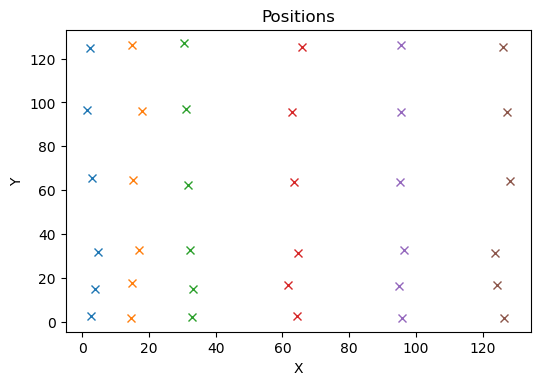

In [116]:
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import datetime
import time

from PIL import Image

from sscPimega import misc

import random
random.seed(0)

def plot_results(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time):
    colormap = 'jet'    
    figure, ax = plt.subplots(3,5,dpi=150,figsize=(10,6))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[2,1].imshow(np.abs(PIE_obj),cmap=colormap)
    crop = 25
    ax[2,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(PIE_probe),cmap=colormap)
    ax[1,0].legend()
    figure.tight_layout()

def set_object_pixel_size(jason,half_size):
    c = 299792458             # Speed of Light [m/s]
    planck = 4.135667662E-18  # Plank constant [keV*s]
    wavelength = planck * c / jason['Energy'] # meters
    jason["wavelength"] = wavelength
    
    # Convert pixel size:
    dx = wavelength * jason['DetDistance'] / ( jason['Binning'] * jason['RestauredPixelSize'] * half_size * 2)

    return dx, jason
    
def convert_probe_positions(dx, probe_positions, offset_topleft = 20):
    """Set probe positions considering maxroi and effective pixel size

    Args:
        difpads (3D array): measured diffraction patterns
        jason (json file): file with the setted parameters and directories for reconstruction
        probe_positions (array): each element is an 2-array with x and y probe positions
        offset_topleft (int, optional): [description]. Defaults to 20.

    Returns:
        object pixel size (float), maximum roi (int), probe positions (array)
    """    

    # Subtract the probe positions minimum to start at 0
    probe_positions[:, 0] -= np.min(probe_positions[:, 0])
    probe_positions[:, 1] -= np.min(probe_positions[:, 1])

    offset_bottomright = offset_topleft #define padding width
    probe_positions[:, 0] = 1E-6 * probe_positions[:, 0] / dx + offset_topleft #shift probe positions to account for the padding
    probe_positions[:, 1] = 1E-6 * probe_positions[:, 1] / dx + offset_topleft #shift probe positions to account for the padding

    return probe_positions, offset_bottomright


def set_object_shape(difpads,jason,filenames,filepaths,acquisitions_folder,offset_topleft = 20):

    ibira_datafolder    = jason['ProposalPath']
    positions_string    = jason['positions_string']

    # Pego a PRIMEIRA medida de posicao, supondo que ela nao tem erro
    measurement_file = filenames[0]
    measurement_filepath = filepaths[0]
    
    # Compute half size of diffraction patterns:
    half_size = difpads.shape[-1] // 2

    # Compute/convert pixel size:
    dx, jason = set_object_pixel_size(jason,half_size)

    probe_positions_file = os.path.join(acquisitions_folder, positions_string, measurement_file[:-5] + '.txt')  # change .hdf5 to .txt extension
    probe_positions = read_probe_positions(os.path.join(ibira_datafolder,probe_positions_file), measurement_filepath)
    probe_positions, offset_bottomright = convert_probe_positions(dx, probe_positions, offset_topleft = offset_topleft)

    maxroi        = int(np.max(probe_positions)) + offset_bottomright
    object_shape  = 2 * half_size + maxroi
    print('Object shape:',object_shape)

    return (object_shape,object_shape), half_size, dx, jason
    
def apply_random_shifts_to_positions(positionsX,positionsY ):
        mu, sigma = 0, 1 # mean and standard deviation
        deltaX = np.random.normal(mu, sigma, positionsX.shape)
        deltaY = np.random.normal(mu, sigma, positionsY.shape)
        return positionsX+deltaX,positionsY+deltaY 

def get_positions_array(random_positions=False):
    positions = [2,16,32,64,96,126]
    # positions = [  2,  10,  18,  26,  34,  42,  50,  58,  66,  74,  82,  90,  98,  106, 114, 122]
    # positions = [2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50, 54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106, 110, 114, 118, 122

    positionsX,positionsY = np.meshgrid(positions,positions)

    if random_positions == True:
        positionsX,positionsY = apply_random_shifts_to_positions(positionsX,positionsY)
        print(positionsX,positionsY)
        
    if 1: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positionsX,positionsY,'x',label='Original')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    return positionsX,positionsY

def apply_invalid_regions(difpad):
    delta = 25
    for i in range(0,difpad.shape[0]):
        difpad[0:difpad.shape[0]:delta] = -1

    for i in range(0,difpad.shape[1]):
        difpad[:,0:difpad.shape[1]:delta] = -1
    return  difpad
    
def get_simulated_data(random_positions=False,use_bad_points=False):

    positionsX,positionsY = get_positions_array(random_positions)
    
    dimension = 128 # Must be < than object!
    
    """ Create Probe """
    x = np.linspace(-1,1,dimension)
    X,Y = np.meshgrid(x,x)
    probe = np.where(X**2 + Y**2 < 0.9,1,0)  # Probe

    """ Create object """
    phase = np.array( np.load('image.npy')) # Load Imagem
    phase = phase - np.min(phase)
    phase = 2*np.pi*phase/np.max(phase) - np.pi # rescale from 0 to 2pi

    magnitude = Image.open('bernardi.png' ).convert('L').resize(phase.shape)
    magnitude = magnitude/np.max(magnitude)
    
    model_object = np.abs(magnitude)*np.exp(-1j*phase)

    difpads = []
    for px,py in zip(positionsX,positionsY):

        """ Exit wave-field """
        W = model_object[py:py+dimension,px:px+dimension]*probe
    
        """ Propagation """
        difpad = np.fft.fft2(W)
        difpad = np.fft.fftshift(difpad)
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
        
        # misc.imshow(np.abs(difpad),(5,5),savename='difpadgrid.png')
        # plt.show()
        # plt.close()

        difpads.append(difpad)

    positions = np.hstack((np.array([positionsY]).T ,np.array([positionsX]).T)) # adjust positionsitions format for proper input
    difpads = np.asarray(difpads)
    
    return difpads, positions, model_object, probe


def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def calculate_recon_error(model,obj):
    error = np.sum(np.abs(model - obj))/model.size
    return error 

def RAAR_update_object(exit_waves, probe, object_shape, positions,epsilon=0.01):

    m,n = probe.shape
    k,l = object_shape

    probeSum  = np.zeros((k,l),dtype=complex)
    waveSum   = np.zeros((k,l),dtype=complex)
    probeInt  = np.abs(probe)**2
    conjProbe = np.conj(probe)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        probeSum[posy:posy + m , posx:posx+n] = probeSum[posy:posy + m , posx:posx+n] + probeInt
        waveSum[posy:posy + m , posx:posx+n]  = waveSum[posy:posy + m , posx:posx+n]  + conjProbe*exit_waves[index] 

    object = waveSum/(probeSum + epsilon)

    return object


def RAAR_update_probe(exit_waves, obj, probe_shape,positions, epsilon=0.01):
    m,n = probe_shape

    objectSum = np.zeros((m,n),dtype=complex)
    waveSum = np.zeros((m,n),dtype=complex)
    objectInt = np.abs(obj)**2
    conjObject = np.conj(obj)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        objectSum = objectSum + objectInt[posy:posy + m , posx:posx+n]
        waveSum = waveSum + conjObject[posy:posy + m , posx:posx+n]*exit_waves[index]

    probe = waveSum/(objectSum + epsilon)

    return probe


def update_exit_wave(wavefront,measurement,experiment_params,epsilon=0.01,propagator = 'fourier'):
    wave_at_detector = propagate_beam(wavefront, experiment_params,propagator=propagator)
    wave_at_detector = np.sqrt(measurement)*wave_at_detector/(np.abs(wave_at_detector)+epsilon)
    # wave_at_detector[measurement>=0] = (np.sqrt(measurement)*wave_at_detector/(np.abs(wave_at_detector)))[measurement>=0]
    updated_exit_wave = propagate_beam(wave_at_detector, (experiment_params[0],experiment_params[1],-experiment_params[2]),propagator=propagator)
    return updated_exit_wave

def PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function=True):
    #TODO: update only where difpad is valid?
    alpha,beta,gamma_obj,gamma_probe,eta_obj,eta_probe,T_lim = mPIE_params

    if use_rPIE_update_function: # rPIE update function
        obj[py:py+offset[0],px:px+offset[1]] = obj[py:py+offset[0],px:px+offset[1]] + gamma_obj*difference*probe.conj()/ ( (1-alpha)*np.abs(probe)**2+alpha*(np.abs(probe)**2).max() )
        # P = P + gamma_probe*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/ ( (1-beta)*np.abs(P)**2+beta*(np.abs(P)**2).max() )
        probe = probe + gamma_probe*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/ ( (1-beta)*np.abs(obj[py:py+offset[0],px:px+offset[1]])**2+beta*(np.abs(obj[py:py+offset[0],px:px+offset[1]])**2).max() )
    else: #ePIE update function
        obj[py:py+offset[0],px:px+offset[1]] = obj[py:py+offset[0],px:px+offset[1]] + alpha*difference*probe.conj()/(np.abs(probe)**2).max()
        probe = probe + beta*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/(np.abs(obj)**2).max()
    return obj, probe

def momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe):
    T_counter += 1 
    if T_counter == T_lim : # T parameter in mPIE paper
        probeVelocity  = probeVelocity*eta_probe + (probe - P_aux)
        objVelocity = objVelocity*eta_obj  + (obj - O_aux)  
        obj = O_aux + objVelocity
        probe = P_aux + probeVelocity 

        O_aux = obj
        P_aux = probe            
        T_counter = 0
        # T_counter = T_lim - 1
    return T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe
    
def RAAR_loop(difpads,positions,obj,probe,RAAR_params,experiment_params, iterations,model):
    t0 = time.perf_counter()
    print("Starting RAAR...")
    
    beta, epsilon = RAAR_params
    dx, wavelength,distance = experiment_params 
    m,n = probe.shape
    exitWaves = np.zeros((len(positions),probe.shape[0],probe.shape[1]),dtype=complex)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        reconBox = obj[posy:posy + m , posx:posx+n]
        exitWaves[index] = probe*reconBox

    error = []
    for iteration in range(0,iterations):

        if iteration%10 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index, pos in enumerate((positions)):
            posy, posx = pos[0], pos[1]
            reconBox = obj[posy:posy + m , posx:posx+n]
            waveToPropagate = 2*probe*reconBox-exitWaves[index]
            exitWaveNew = update_exit_wave(waveToPropagate,difpads[index],experiment_params,epsilon=epsilon)
            exitWaves[index] = beta*(exitWaves[index] + exitWaveNew) + (1-2*beta)*probe*reconBox

        probe = RAAR_update_probe(exitWaves, obj, probe.shape,positions, epsilon=epsilon)
        obj   = RAAR_update_object(exitWaves, probe, obj.shape, positions,epsilon=epsilon)

        error.append(calculate_recon_error(model,obj)) #absolute error
    return obj, probe, error, time.perf_counter()-t0

def mPIE_loop(difpads, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations,model_obj):
    t0 = time.perf_counter()
    print("Starting PIE...")
    
    mPIE = True
    use_rPIE_update_function = True
    
    _,_,_,_,eta_obj,eta_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    # difpads = np.asarray(difpads)
    # obj = np.asarray(object_guess)
    # probe = np.asarray(probe_guess)
    obj = object_guess
    probe = probe_guess
    
    print(type(obj),obj.shape)
    error_list = []
    for j in range(iterations):

        if j%10 ==0 : print(f'\tIteration {j}/{iterations}')
        error, O_aux, P_aux = 0, obj+0, probe+0
        for i in np.random.permutation(len(difpads)):  
        # for i in range(len(difpads)):  
            
            px, py = positions[:,1][i],  positions[:,0][i]
            measurement = difpads[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)
            
            difference = exitWaveNew - exitWave
            
            obj, probe = PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function)
            
            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe)

                
        error_list.append(calculate_recon_error(model_obj,obj)) #absolute error
            
        # if j%2 == 0: # Print iteration
        #     figure, subplot = plt.subplots(1,2)
        #     subplot[0].imshow(np.abs(obj.get()),cmap=colormap)
        #     subplot[1].imshow(np.abs(probe.get()),cmap=colormap)
        #     subplot[0].set_title('Object')
        #     subplot[1].set_title('Probe')
        #     figure.suptitle(f'Iteration #{j}')
        #     plt.show()
        #     plt.close()

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe, error_list, time.perf_counter() - t0

    
""" MAIN CODE """
    
difpads, positions, model_obj, model_probe = get_simulated_data(random_positions=True)
probe_guess = model_probe*np.exp(-1j*np.random.rand(*model_probe.shape))
obj_guess = np.ones_like(model_obj) # constant object
obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j

""" Experiment Parameters """
position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
c_speed = 299792458    # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
experiment_params = dx, wavelength,distance
oversampling_ratio = wavelength*distance/(position_step*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ",oversampling_ratio)

iterations = 10

""" mPIE params """
if 0: # suggested min from paper
    alpha, beta = 0.05, 0.5
    gamma_obj, gamma_probe = 0.1, 0.2
    eta_obj, eta_probe = 0.5, 0.75
    T_lim = 10
else: # suggested max from paper
    alpha, beta = 0.25, 5
    gamma_obj, gamma_probe = 0.5, 1
    eta_obj, eta_probe = 0.9, 0.99
    T_lim = 100 
mPIE_params = (alpha,beta,gamma_obj,gamma_probe,eta_obj,eta_probe,T_lim)
    
""" RAAR params """
beta = 0.995
epsilon = 0.01
RAAR_params = (beta,epsilon)



In [93]:
PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE_loop(difpads, positions,obj_guess,probe_guess, mPIE_params, experiment_params, iterations, model_obj)
RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(difpads,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

Starting PIE...
<class 'numpy.ndarray'> (256, 256)
	Iteration 0/300
	Iteration 10/300
	Iteration 20/300
	Iteration 30/300
	Iteration 40/300
	Iteration 50/300
	Iteration 60/300
	Iteration 70/300
	Iteration 80/300
	Iteration 90/300
	Iteration 100/300
	Iteration 110/300
	Iteration 120/300
	Iteration 130/300
	Iteration 140/300
	Iteration 150/300
	Iteration 160/300
	Iteration 170/300
	Iteration 180/300
	Iteration 190/300
	Iteration 200/300
	Iteration 210/300
	Iteration 220/300
	Iteration 230/300
	Iteration 240/300
	Iteration 250/300
	Iteration 260/300
	Iteration 270/300
	Iteration 280/300
	Iteration 290/300
Starting RAAR...
	Iteration 0/300
	Iteration 10/300
	Iteration 20/300
	Iteration 30/300
	Iteration 40/300
	Iteration 50/300
	Iteration 60/300
	Iteration 70/300
	Iteration 80/300
	Iteration 90/300
	Iteration 100/300
	Iteration 110/300
	Iteration 120/300
	Iteration 130/300
	Iteration 140/300
	Iteration 150/300
	Iteration 160/300
	Iteration 170/300
	Iteration 180/300
	Iteration 190/300
	Ite

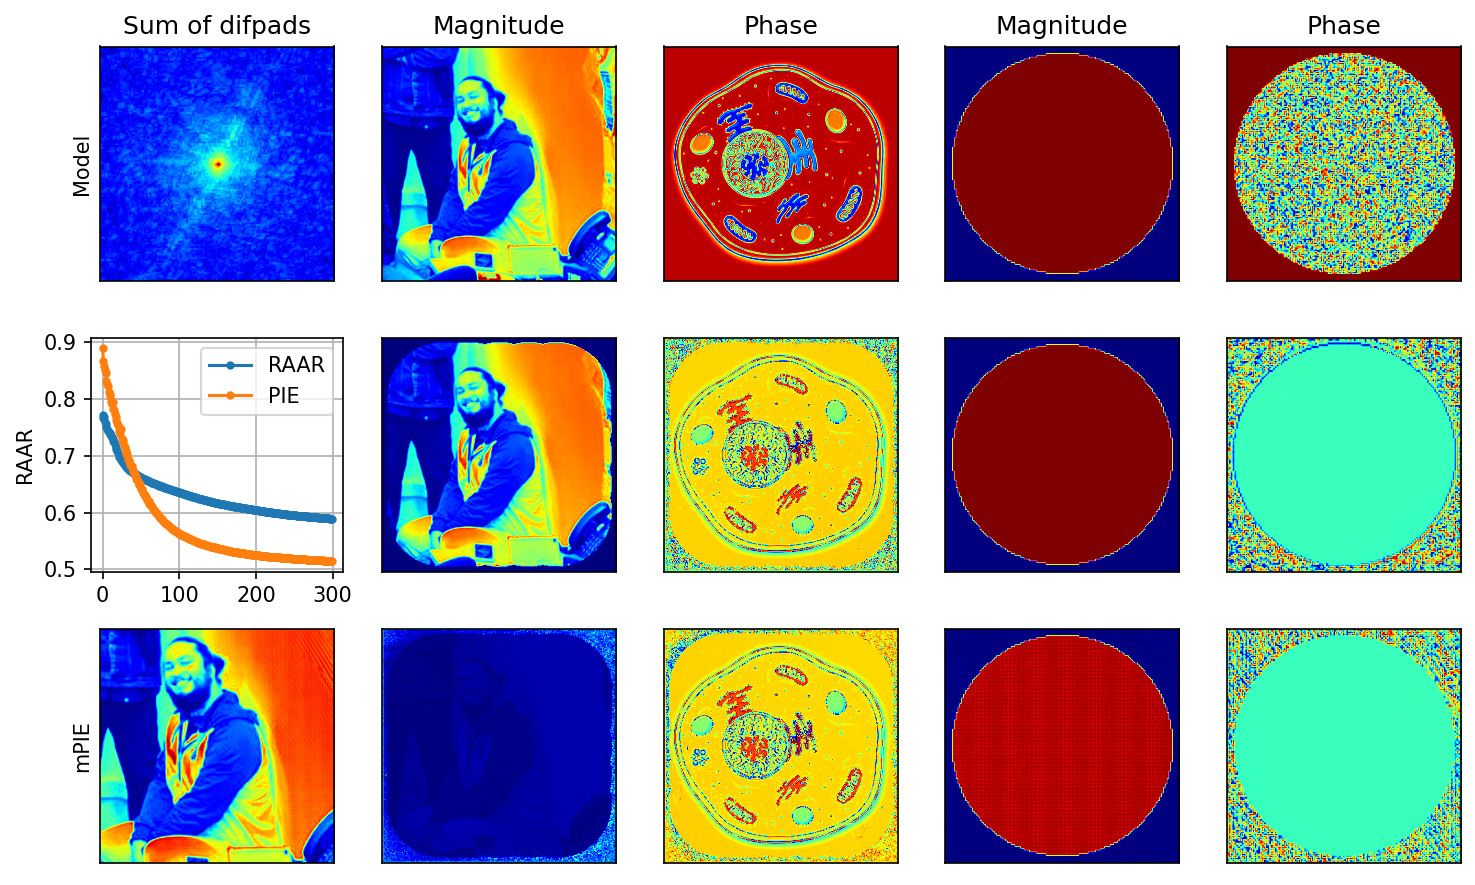

In [104]:
plot_results(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time)